## Triton on SageMaker - This notebook shows how you can take a resnet model and create a traced model and leverage the Pytorch back end for Triton


---

This notebook's CI test result for us-west-2 is as follows. CI test results in other regions can be found at the end of the notebook. 

![This us-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-2/sagemaker-triton|resnet50|jit_trace|Triton_CPU_JIT_MME.ipynb)

---


Amazon SageMaker is a fully managed service for data science and machine learning workflows. It helps data scientists and developers to prepare, build, train, and deploy high-quality ML models quickly by bringing together a broad set of capabilities purpose-built for ML.

Now, NVIDIA Triton Inference Server can be used to serve models for inference in Amazon SageMaker. Thanks to the new NVIDIA Triton container image, you can easily serve ML models and benefit from the performance optimizations, dynamic batching, and multi-framework support provided by NVIDIA Triton. Triton helps maximize the utilization of GPU and CPU, further lowering the cost of inference.

This notebook was tested on Studio with ml.g4dn.xlarge which comes with 1 GPU and with ml.m5.large which is a CPU based machine only
Contents

    Introduction to NVIDIA Triton Server
    Set up the environment
    Basic: PyTorch resnet50 model for Object detection
    PyTorch: JIT Trace the model and create a Scripted model
    PyTorch: Testing the JIT Traced model 
    PyTorch: Packaging model files and uploading to s3
    PyTorch: Create SageMaker Endpoint
    PyTorch: Run inference
    PyTorch: Leverage the Predictions to view the results for Object detection
    PyTorch: Terminate endpoint and clean up artifacts


## Introduction to NVIDIA Triton Server

NVIDIA Triton Inference Server was developed specifically to enable scalable, cost-effective, and easy deployment of models in production. NVIDIA Triton Inference Server is open-source inference serving software that simplifies the inference serving process and provides high inference performance.

Some key features of Triton are:

    Support for Multiple frameworks: Triton can be used to deploy models from all major frameworks. Triton supports TensorFlow GraphDef, TensorFlow SavedModel, ONNX, PyTorch TorchScript, TensorRT, RAPIDS FIL for tree based models, and OpenVINO model formats.
    Model pipelines: Triton model ensemble represents a pipeline of one or more models or pre/post processing logic and the connection of input and output tensors between them. A single inference request to an ensemble will trigger the execution of the entire pipeline.
    Concurrent model execution: Multiple models (or multiple instances of the same model) can run simultaneously on the same GPU or on multiple GPUs for different model management needs.
    Dynamic batching: For models that support batching, Triton has multiple built-in scheduling and batching algorithms that combine individual inference requests together to improve inference throughput. These scheduling and batching decisions are transparent to the client requesting inference.
    Diverse CPUs and GPUs: The models can be executed on CPUs or GPUs for maximum flexibility and to support heterogeneous computing requirements.

Note: This initial release of NVIDIA Triton on SageMaker will only support a single model. Future releases will have multi-model support. A minimal config.pbtxt configuration file is required in the model artifacts. This release doesn't support inferring the model config automatically.
Set up the environment

Installs the dependencies required to package the model and run inferences using Triton server.

Also define the IAM role that will give SageMaker access to the model artifacts and the NVIDIA Triton ECR image.

The purpose of this file is to show the ability to take a pytorch computer vision model and create a scripted model 
which can then be leveraged by Triton using the pytorch back end.

The other option is to build using a python back end but in that we loose the performance gains by compilation to native format


In this example we will take a open source computer vision model and convert into a JIT Traced format and leverage pytorch back end to serve

The model will return 3 tensors for bounded box,



In [ ]:
# imports
import boto3, json, sagemaker, time
from sagemaker import get_execution_role
import numpy as np
from PIL import Image

# account mapping for SageMaker MME Triton Image
account_id_map = {
    "us-east-1": "785573368785",
    "us-east-2": "007439368137",
    "us-west-1": "710691900526",
    "us-west-2": "301217895009",
    "eu-west-1": "802834080501",
    "eu-west-2": "205493899709",
    "eu-west-3": "254080097072",
    "eu-north-1": "601324751636",
    "eu-south-1": "966458181534",
    "eu-central-1": "746233611703",
    "ap-east-1": "110948597952",
    "ap-south-1": "763008648453",
    "ap-northeast-1": "941853720454",
    "ap-northeast-2": "151534178276",
    "ap-southeast-1": "324986816169",
    "ap-southeast-2": "355873309152",
    "cn-northwest-1": "474822919863",
    "cn-north-1": "472730292857",
    "sa-east-1": "756306329178",
    "ca-central-1": "464438896020",
    "me-south-1": "836785723513",
    "af-south-1": "774647643957",
}

region = boto3.Session().region_name
if region not in account_id_map.keys():
    raise ("UNSUPPORTED REGION")

base = "amazonaws.com.cn" if region.startswith("cn-") else "amazonaws.com"
mme_triton_image_uri = (
    "{account_id}.dkr.ecr.{region}.{base}/sagemaker-tritonserver:22.07-py3".format(
        account_id=account_id_map[region], region=region, base=base
    )
)
print(mme_triton_image_uri)

#### Install some libraries we need to convert the model.

The format is to create a wrapper on top of the model and trace it with summy inputs to create a traced model

In [ ]:
!pip install -qU pip awscli boto3 sagemaker
!pip install -qU nvidia-pyindex
!pip install -qU tritonclient[http]

### To create the JIT Trace model you need

FOR GPU based instances we leverage -- Torch version 1.12.1 Torch Vision 0.13.1 and Cuda library 11.3 and so uncomment and use that 

The GPU instance we need to run the notebook - this has been tested on a ml.g4dn.xlarge which comes with 1 gpu

In [ ]:
#!pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 --extra-index-url https://download.pytorch.org/whl/cu113
!pip install torch torchvision

In [ ]:
import os
import tarfile
import boto3, json, sagemaker, time
from sagemaker import get_execution_role
import concurrent.futures
import time

### Create a JIT Traced model

#### Few points to note: The traced models is provided in the zip file which can be used as is
1. The Model after trace is now returing outputs like OUTPUT_0 , 1 etc
2. To change them to named outputs can be done for now we will leave them as is since it is just a label
3. To full create a jit traced model we will need to provide a sample inputs and hence for now we have created a scripted model
4. The TORCH and the TORCHSCRIPT libraries would need to match the container and hence we use the specific ones mentioned above

In [ ]:
import torch
from pathlib import Path

print(torch.__version__)
import torchvision

print(torchvision.__version__)

In [ ]:
torch.cuda.is_available()

In [ ]:
# set the device we will be using to run the model
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

**Convert the model into Serving mode**

In [ ]:
from torchvision.models import detection
import numpy as np
import argparse
import pickle
import torch

#### Approaches

Approach # 1 Create a stack of the predictions 

Approach # 2 can be to ad a dimension along the batch axis

For now we are stack predictions and return back

In [ ]:
class JitWrapper(torch.nn.Module):
    # Modify original model to take int8 inputs and return Tuple[Tensor] results
    def __init__(self, model):
        super().__init__()
        self.model = model
        if torch.cuda.is_available():
            self.model.cuda()
        self.model.eval()

    @torch.jit.ignore
    def debug_output(self, preds):
        test_o = [pred["boxes"] for pred in preds]
        print(f"{type(test_o[0])}, {test_o[0]}, {type(test_o)},", flush=True)

    def forward(self, batch_img):
        orig_type = batch_img.dtype

        DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Using {} device".format(DEVICE))
        batch_img = batch_img.to(DEVICE)

        with torch.no_grad():
            # this will make the jit model work with arbitrary batch sizes by splitting the input tensor along the batch axis
            preds = self.model([t.squeeze() for t in torch.split(batch_img.type(torch.float32), 1)])

            bboxes = torch.stack([pred["boxes"] for pred in preds])
            labels = torch.stack([pred["labels"] for pred in preds])
            scores = torch.stack([pred["scores"] for pred in preds])

            bboxes = torch.stack(
                [torch.nn.utils.rnn.pad_sequence([pred["boxes"] for pred in preds])]
            )
            labels = torch.stack(
                [torch.nn.utils.rnn.pad_sequence([pred["labels"] for pred in preds])]
            )
            scores = torch.stack(
                [torch.nn.utils.rnn.pad_sequence([pred["scores"] for pred in preds])]
            )
            print(f"bboxes.shape={bboxes.shape}:")

        return bboxes, labels, scores

#### Approach for doing JIT SCRIPT where in at run time we pass in the required tensors

This has the advantage of no needing to do cuda translations

In [ ]:
class JitScriptWrapper(torch.nn.Module):
    # Modify original model to take int8 inputs and return Tuple[Tensor] results
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.model.eval()

    @torch.jit.ignore
    def debug_output(self, preds):
        test_o = [pred["boxes"] for pred in preds]
        print(f"{type(test_o[0])}, {test_o[0]}, {type(test_o)},", flush=True)

    def forward(self, inp):
        orig_type = inp.dtype
        DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        with torch.no_grad():
            preds = self.model([t.squeeze() for t in torch.split(inp.type(torch.float32), 1)])

            bboxes = torch.stack([pred["boxes"] for pred in preds])
            labels = torch.stack([pred["labels"] for pred in preds])
            scores = torch.stack([pred["scores"] for pred in preds])

            bboxes = torch.stack(
                [torch.nn.utils.rnn.pad_sequence([pred["boxes"] for pred in preds])]
            )
            labels = torch.stack(
                [torch.nn.utils.rnn.pad_sequence([pred["labels"] for pred in preds])]
            )
            scores = torch.stack(
                [torch.nn.utils.rnn.pad_sequence([pred["scores"] for pred in preds])]
            )
            print(f"bboxes.shape={bboxes.shape}:")

        return bboxes, labels, scores

In [ ]:
from torchvision import transforms

#
# Load the image
#
from PIL import Image

img_dog = Image.open("./shiba_inu_dog.jpg").convert("RGB")

#
# Create a preprocessing pipeline
#
preprocess = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
#
# Pass the image for preprocessing and the image preprocessed
#
img_dog_preprocessed = preprocess(img_dog)
print(img_dog_preprocessed.shape)
#
# Reshape, crop, and normalize the input tensor for feeding into network for evaluation
#
batch_img_dog_tensor = torch.unsqueeze(img_dog_preprocessed, 0)
print(batch_img_dog_tensor.shape)

In [ ]:
from torchvision import transforms
import numpy as np
import torch

#
# Load the image
#
from PIL import Image

img_dog = Image.open("./image3.jpg").convert("RGB").resize((224, 224))


image_array = np.array(
    img_dog
)  # -- torch transofr does it -- .transpose(2,0,1) # flip so channel comes as first axis
print(image_array.shape)


# define the torchvision image transforms
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)
image_array_tensor = transform(image_array)  # dtype=torch.float16)
print(image_array_tensor.shape)
#
# Reshape, crop, and normalize the input tensor for feeding into network for evaluation
#
batch_img_dog_tensor = torch.unsqueeze(image_array_tensor, 0)
print(batch_img_dog_tensor.shape)

In [ ]:
print(image_array_tensor.shape)
print(image_array_tensor.numpy().shape)

In [ ]:
batch_img_dog_tensor.to(DEVICE)[0].shape

In [ ]:
print(len([t.squeeze() for t in torch.split(batch_img_dog_tensor, 1)]))
[t.squeeze() for t in torch.split(batch_img_dog_tensor, 1)][0].shape

In [ ]:
print(len([t.squeeze() for t in torch.split(img_dog_preprocessed, 1)]))
[t.squeeze() for t in torch.split(img_dog_preprocessed, 1)][0].shape

### Use the Open source Model for object detection


We will JIT Trace the model and save the compiled version and use that for the Triton back end

In [ ]:
import torch
import torchvision

min_size = 800

model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True, min_size=min_size)

model.eval()
if torch.cuda.is_available():
    model.cuda()

x = [torch.rand(3, 300, 400).to(DEVICE), torch.rand(3, 500, 400).to(DEVICE)]
predictions = model(x)

In [ ]:
predictions[0].keys()

#### Generate some local predictions - add a batch dimetnion to the 1 image we have

In [ ]:
print(batch_img_dog_tensor.shape)
print(batch_img_dog_tensor.type())

In [ ]:
image_cuda = img_dog_preprocessed.to(DEVICE)
image_cuda = image_cuda.unsqueeze(0)  # add a batch dimension
print(image_cuda.shape)
with torch.no_grad():
    outputs = model(image_cuda)  # get the predictions on the image

outputs[0]
# model([img_dog_preprocessed,img_dog_preprocessed]) # returns 2 tensors

In [ ]:
# test int and float conversions and prediction

int_batch = batch_img_dog_tensor.type(torch.uint8)
print([t.squeeze() for t in torch.split(int_batch.type(torch.float32), 1)][0].shape)
print(img_dog_preprocessed.to(DEVICE).unsqueeze(0).shape)
print(
    img_dog_preprocessed.to(DEVICE).unsqueeze(0)[0].shape
)  # unsqueze and list with split is the same thing - ad BATCH dimension

# local_model(int_batch.type(torch.float16) )

In [ ]:
print(batch_img_dog_tensor.shape)
result_pred = model(batch_img_dog_tensor.to(DEVICE))
result_pred

In [ ]:
result_pred[0]

In [ ]:
# get all the scores
scores = list(result_pred[0]["scores"].detach().cpu().numpy())

bboxes = result_pred[0]["boxes"].detach().cpu().numpy()
labels = result_pred[0]["labels"].cpu().numpy()

for i, box in enumerate(bboxes):
    print(i, box)
    print(int(box[0]), int(box[1]))
    print(int(box[2]), int(box[3]))

In [ ]:
image_array.shape

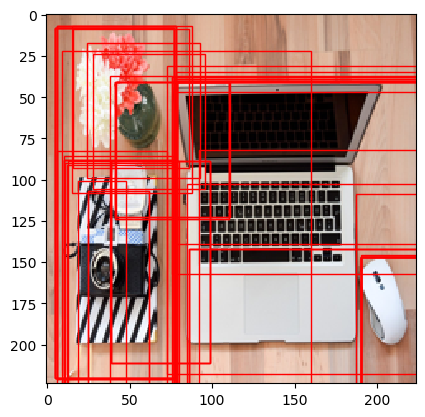

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(image_array)  ## transpose it back

# Create a Rectangle patch
for i, box in enumerate(bboxes):
    rect = patches.Rectangle(
        (int(box[0]), int(box[1])),
        int(box[2]),
        int(box[3]),
        linewidth=1,
        edgecolor="r",
        facecolor="none",
    )
    # rect = patches.Rectangle((50, 100), 40, 30, linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()

#### JIT Trace the model 

Script could be the other option to create a model 
Script could be useful to avoid Device conversion

In [ ]:
traced_wrapper = JitWrapper(model)


print(DEVICE)


with torch.no_grad():
    traced_model = torch.jit.trace(
        traced_wrapper, (batch_img_dog_tensor), strict=False
    )  # image_array_tensors)

print(traced_model.code)

In [ ]:
scripted_wrapper = JitScriptWrapper(model)
# scripted_model = torch.jit.script(scripted_wrapper)
# print(scripted_model.code)

In [ ]:
traced_result = traced_model(batch_img_dog_tensor.to(DEVICE))
traced_result[0].shape  # -- bounding boxes

In [ ]:
traced_result[1].shape  # classes

In [ ]:
traced_result[2].shape  # connfidence

In [ ]:
print(traced_result[0][0].shape)  # 65 shapes
print(traced_result[0][0].shape[0])  # Length of the bounding boxes returned
print(traced_result[0][0][0])  # one of the bounding boxes
print(traced_result[0][0][2])  # one of the bounding boxes

#### Show the traced results

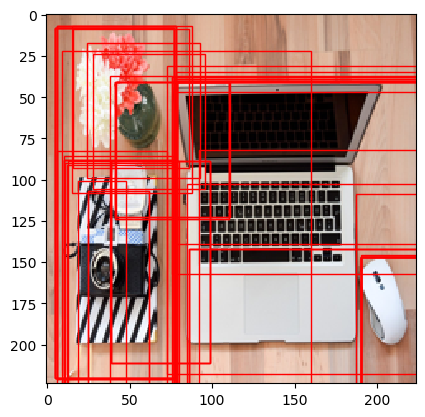

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(image_array)  ## transpose it back

# Create a Rectangle patch
for i in range(traced_result[0][0].shape[0]):
    box = traced_result[0][0][i][0]
    rect = patches.Rectangle(
        (int(box[0]), int(box[1])),
        int(box[2]),
        int(box[3]),
        linewidth=1,
        edgecolor="r",
        facecolor="none",
    )
    # rect = patches.Rectangle((50, 100), 40, 30, linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()

#### Create the required triton config files

In [ ]:
!mkdir -p jit-resnet-v1-model
!mkdir -p jit-resnet-v1-model/1
!rm jit-resnet-v1-model/1/model.pt

traced_model.save("./jit-resnet-v1-model/1/model.pt")

!rm -r jit-resnet-v1-model/1/.ip*
!ls -alrt jit-resnet-v1-model/1

#### For GPU BASED Instances change the KIND_CPU to say KIND_GPU

In [ ]:
%%writefile jit-resnet-v1-model/config.pbtxt
name: "jit-resnet-v1-model"
platform: "pytorch_libtorch"
max_batch_size: 12
input {
  name: "INPUT__0"
  data_type: TYPE_FP32
  dims: [3, 224, 224]
}
output {
  name: "OUTPUT__0"
  data_type: TYPE_FP32
  dims: [-1]
}
output {
  name: "OUTPUT__1"
  data_type: TYPE_INT64
  dims: [-1]
}

output {
  name: "OUTPUT__2"
  data_type: TYPE_FP32
  dims: [-1]
}

instance_group {
  count: 3
  kind: KIND_CPU
}

#### Now create the TAR ball and upload

In [ ]:
model_path = "jit-resnet-v1-model"

output_filename = f"jit-resnet-v1-model.tar.gz"
with tarfile.open(output_filename, "w:gz") as tar:
    tar.add(model_path, arcname=model_path)
sm_client = boto3.client(service_name="sagemaker")

import sagemaker

role = sagemaker.get_execution_role()  # execution role for the endpoint
sess = sagemaker.session.Session()  # sagemaker session for interacting with different AWS APIs
def_bucket = sess.default_bucket()  # bucket to house artifacts
# sagemaker_session = sagemaker.Session(boto_session=boto3.Session())
# role = get_execution_role()

model_uri = sess.upload_data(
    output_filename, def_bucket, "triton/cv/jit/temp_model_tri_cv"
)  # - file, bucket, key_prefix
# model_uri = sess.upload_data(path=output_filename, key_prefix="temp_model")
print(model_uri)
os.remove(output_filename)

#### Create the End point

In [ ]:
mme_path = f"s3://{def_bucket}/triton/cv/jit/temp_model_tri_cv/"  # model_uri.split("jit-res")[0]
mme_path

In [ ]:
from sagemaker.utils import name_from_base

# m_name =  name_from_base(f"{model_uri.rsplit('/')[-2]}")
m_name = name_from_base(f"jit-resnet-v1")
print(m_name)
model_uri.rsplit("/")[-2]

print(mme_triton_image_uri)


container = {
    "Image": mme_triton_image_uri,
    "ModelDataUrl": mme_path,  # model_uri,
    "Mode": "MultiModel",
    "Environment": {
        # "SAGEMAKER_TRITON_DEFAULT_MODEL_NAME": "resnet_fpn_v2",
        "SAGEMAKER_TRITON_THREAD_COUNT": "10",  # "200",
        "SAGEMAKER_TRITON_BUFFER_MANAGER_THREAD_COUNT": "5",  # "10"
        # "SAGEMAKER_TRITON_SHM_DEFAULT_BYTE_SIZE" : "20000000", #"1677721600", #"16777216000", "16777216"
        # "SAGEMAKER_TRITON_SHM_GROWTH_BYTE_SIZE": "1048576"
    },
}
sm_client = boto3.client(service_name="sagemaker")
try:
    create_model_response = sm_client.create_model(
        ModelName=m_name, ExecutionRoleArn=get_execution_role(), PrimaryContainer=container
    )
    print(create_model_response)

    create_endpoint_config_response = sm_client.create_endpoint_config(
        EndpointConfigName=m_name,
        ProductionVariants=[
            {
                "InstanceType": "ml.m5.large",  # "ml.g4dn.2xlarge",
                "InitialVariantWeight": 1,
                "InitialInstanceCount": 1,
                "ModelName": m_name,
                "VariantName": "AllTraffic",
            }
        ],
    )
    print(create_endpoint_config_response)
except Exception as e:
    print(f"Error: {e}\n Trying to create endpoint")


response = sm_client.create_endpoint(EndpointName=m_name, EndpointConfigName=m_name)
print(response)

In [ ]:
import time

resp = sm_client.describe_endpoint(EndpointName=m_name)
status = resp["EndpointStatus"]
print("MME:Model:endpoint:Triton:Status: " + status)

while status == "Creating":
    time.sleep(30)
    resp = sm_client.describe_endpoint(EndpointName=m_name)
    status = resp["EndpointStatus"]
    print("MMEmodel:triton:Status: " + status)

print("Arn: " + resp["EndpointArn"])
print("MME:model:triton:Status: " + status)

In [ ]:
import requests
from io import BytesIO
from PIL import Image
import concurrent.futures
import tritonclient.http as httpclient
from botocore.config import Config
import numpy as np
import random
import boto3
import time

In [ ]:
batch_img_dog_tensor.type(torch.float32).numpy().shape

In [ ]:
inputs = []
outputs = []

input_data = batch_img_dog_tensor.type(
    torch.float32
).numpy()  # -- torch.tensor(image_batch[0]).unsqueeze(0).numpy()
print(input_data.shape)

runtime_sm_client = boto3.client("sagemaker-runtime")
# inputs.append(httpclient.InferInput("INPUT__0", [ len(input_data),h, w,3], "UINT8"))

inputs = [httpclient.InferInput("INPUT__0", input_data.shape, "FP32")]
inputs[0].set_data_from_numpy(input_data, binary_data=True)
outputs_data = [
    httpclient.InferRequestedOutput(f"OUTPUT__{n}", binary_data=False) for n in range(3)
]

request_body, header_length = httpclient.InferenceServerClient.generate_request_body(
    inputs, outputs=outputs_data
)


response_invoke = runtime_sm_client.invoke_endpoint(
    EndpointName=m_name,
    ContentType="application/vnd.sagemaker-triton.binary+json;json-header-size={}".format(
        header_length
    ),
    Body=request_body,
    TargetModel="jit-resnet-v1-model.tar.gz",
)
header_length_prefix = "application/vnd.sagemaker-triton.binary+json;json-header-size="
header_length_str = response_invoke["ContentType"][len(header_length_prefix) :]
if not header_length_str:
    header_length_str = "0"
# result = httpclient.InferenceServerClient.parse_response_body(response_invoke["Body"].read())
# result
binary_response = response_invoke["Body"].read()
binary_response

#### Compare the Model prediction to the original one

In [ ]:
import json

r = json.loads(binary_response.decode())
r.keys()

In [ ]:
bboxes = np.array(r["outputs"][0]["data"])
bboxes = bboxes.reshape(int(bboxes.shape[0] / 4), 4)
bboxes.shape

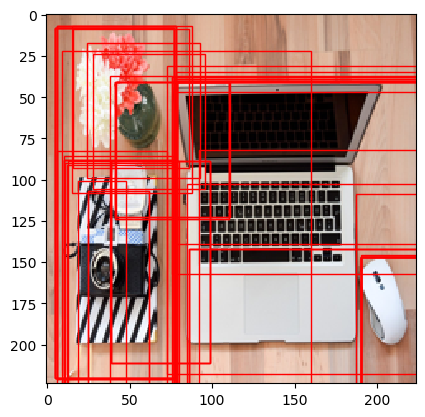

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(image_array)  ## transpose it back

# Create a Rectangle patch
for i, box in enumerate(bboxes):
    rect = patches.Rectangle(
        (int(box[0]), int(box[1])),
        int(box[2]),
        int(box[3]),
        linewidth=1,
        edgecolor="r",
        facecolor="none",
    )
    # rect = patches.Rectangle((50, 100), 40, 30, linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()

## We can see All 3 methods match for Object Detection

#### For any stress test we can use this method below

In [ ]:
def invoke_endpoint(images, endpoint_name, target_model="model.tar.gz"):  # -
    inputs = []
    outputs = []
    input_data = np.asarray(images, dtype="float32")  # passing in a numpy aray already
    print(input_data.shape)

    inputs = [httpclient.InferInput("INPUT__0", images.shape, "FP32")]
    inputs[0].set_data_from_numpy(input_data, binary_data=True)
    outputs = [httpclient.InferRequestedOutput(f"OUTPUT__{n}", binary_data=False) for n in range(3)]

    request_body, header_length = httpclient.InferenceServerClient.generate_request_body(
        inputs, outputs=outputs
    )

    runtime_sm_client = boto3.client(
        "sagemaker-runtime",
        region_name="eu-west-1",
        config=Config(
            connect_timeout=5,
            read_timeout=60,  # 120,
            retries={"max_attempts": 2, "mode": "standard"},  # 20
        ),
    )

    response_invoke = runtime_sm_client.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType="application/vnd.sagemaker-triton.binary+json;json-header-size={}".format(
            header_length
        ),
        Body=request_body,
        TargetModel=target_model,
    )

    header_length_prefix = "application/vnd.sagemaker-triton.binary+json;json-header-size="
    header_length_str = response_invoke["ContentType"][len(header_length_prefix) :]
    if not header_length_str:
        header_length_str = "0"
    result = httpclient.InferenceServerClient.parse_response_body(response_invoke["Body"].read())
    return result

In [ ]:
%%time
st_time = time.time()

result = ""  # invoke_endpoint(batch_img_dog_tensor, m_name, 'jit-resnet-v1-model.tar.gz')

print(f"Test finished for 1 batch images::result={result}::")

### Optional Stress test the end point

In [ ]:
import numpy as np

print("Starting invocation for model:: please wait ...")
results = []
for i in range(0, 50):
    start = time.time()
    # invoke_endpoint(batch_img_dog_tensor, m_name, 'jit-resnet-v1-model.tar.gz')
    results.append((time.time() - start) * 1000)
print("\nPredictions for model latency: \n")
print("\nP95: " + str(np.percentile(results, 95)) + " ms\n")
print("P90: " + str(np.percentile(results, 90)) + " ms\n")
print("Average: " + str(np.average(results)) + " ms\n")

In [ ]:
print("\nPredictions for model latency: \n")
print("\nP95: " + str(np.percentile(results, 95)) + " ms\n")
print("P90: " + str(np.percentile(results, 90)) + " ms\n")
print("Average: " + str(np.average(results)) + " ms\n")

In [ ]:
from multiprocessing import cpu_count

print(m_name)
cpu_count()

#### Leverage multi process to Stress test the end point

In [ ]:
import numpy as np
import time
import traceback


def run_worker(proc_id):
    # print("Starting invocation for model:: please wait ...")
    start_worker = time.time()
    results = [0]
    error_count = 0
    total_count = 0

    while (
        time.time() - start_worker
    ) < 180:  # -- 300 sec  -- 1 hour 3600    2 hour 7200 is 4 is 14400
        start = time.time()
        try:
            total_count = total_count + 1
            # invoke_endpoint(batch_img_dog_tensor, m_name, 'jit-resnet-v1-model.tar.gz')
            results.append((time.time() - start) * 1000)
        except:
            # print(traceback.format_exc())
            error_count = error_count + 1
            time.sleep(0.05)

    print(
        f"{np.percentile(results, 95)} ms:total_success_count={total_count}::error_count={error_count}::"
    )
    return f"{np.percentile(results, 95)} ms:total_success_count={total_count}::error_count={error_count}::"

In [ ]:
# create a process pool
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from multiprocessing import Pool
from multiprocessing import cpu_count

max_workers_cpu = 1  # cpu_count() # -*2
print(f"Max_A-Sync:processes={max_workers_cpu}")

#### Use a Thread Pool 

In [ ]:
result_pool_list = []
print(max_workers_cpu)
with ThreadPoolExecutor(max_workers=(max_workers_cpu + 10)) as pool:
    # call a function
    for worker in range(max_workers_cpu):
        result_p = ""  # pool.submit(run_worker, worker )
        result_pool_list.append(result_p)

    for result_p in result_pool_list:
        result_p  # .result() # blocks

#### Use a Multi Process Pool 

In [ ]:
# with ProcessPoolExecutor(max_workers=max_workers_cpu) as executor:
result_pool_list = []
print(max_workers_cpu)
result_list = []


def async_call_back(result):
    result_list.append(result)


with Pool(processes=max_workers_cpu) as pool:
    # call a function
    for worker in range(max_workers_cpu):
        result_p = (
            ""  # pool.apply_async(func=run_worker, args=(worker,) , callback = async_call_back)
        )
        result_pool_list.append(result_p)

    for result_p in result_pool_list:
        result_p  # .wait()

In [ ]:
result_list

### Clean up

In [ ]:
sm_client = boto3.client(service_name="sagemaker")
try:
    sm_client.delete_endpoint(EndpointName=m_name)
    sm_client.delete_endpoint_config(EndpointConfigName=m_name)
    sm_client.delete_model(ModelName=m_name)
except:
    pass

##### Helper methods as sample to load images in triton format

In [ ]:
import tritonclient.http as httpclient


def get_sample_image():
    image_path = "./shiba_inu_dog.jpg"
    img = Image.open(image_path).convert("RGB")
    img = img.resize((224, 224))
    img = (np.array(img).astype(np.float32) / 255) - np.array(
        [0.485, 0.456, 0.406], dtype=np.float32
    ).reshape(1, 1, 3)
    img = img / np.array([0.229, 0.224, 0.225], dtype=np.float32).reshape(1, 1, 3)
    img = np.transpose(img, (2, 0, 1))
    return img.tolist()


def _get_sample_image_binary(input_name, output_name):
    inputs = []
    outputs = []
    inputs.append(httpclient.InferInput(input_name, [1, 3, 224, 224], "FP32"))
    input_data = np.array(get_sample_image(), dtype=np.float32)
    input_data = np.expand_dims(input_data, axis=0)
    inputs[0].set_data_from_numpy(input_data, binary_data=True)
    outputs.append(httpclient.InferRequestedOutput(output_name, binary_data=True))
    request_body, header_length = httpclient.InferenceServerClient.generate_request_body(
        inputs, outputs=outputs
    )
    return request_body, header_length


def get_sample_image_binary_pt():
    return _get_sample_image_binary("INPUT__0", "OUTPUT__0")


def get_sample_image_binary_trt():
    return _get_sample_image_binary("input", "output")

## Notebook CI Test Results

This notebook was tested in multiple regions. The test results are as follows, except for us-west-2 which is shown at the top of the notebook.

![This us-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-1/sagemaker-triton|resnet50|jit_trace|Triton_CPU_JIT_MME.ipynb)

![This us-east-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-2/sagemaker-triton|resnet50|jit_trace|Triton_CPU_JIT_MME.ipynb)

![This us-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-1/sagemaker-triton|resnet50|jit_trace|Triton_CPU_JIT_MME.ipynb)

![This ca-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ca-central-1/sagemaker-triton|resnet50|jit_trace|Triton_CPU_JIT_MME.ipynb)

![This sa-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/sa-east-1/sagemaker-triton|resnet50|jit_trace|Triton_CPU_JIT_MME.ipynb)

![This eu-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-1/sagemaker-triton|resnet50|jit_trace|Triton_CPU_JIT_MME.ipynb)

![This eu-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-2/sagemaker-triton|resnet50|jit_trace|Triton_CPU_JIT_MME.ipynb)

![This eu-west-3 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-3/sagemaker-triton|resnet50|jit_trace|Triton_CPU_JIT_MME.ipynb)

![This eu-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-central-1/sagemaker-triton|resnet50|jit_trace|Triton_CPU_JIT_MME.ipynb)

![This eu-north-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-north-1/sagemaker-triton|resnet50|jit_trace|Triton_CPU_JIT_MME.ipynb)

![This ap-southeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-1/sagemaker-triton|resnet50|jit_trace|Triton_CPU_JIT_MME.ipynb)

![This ap-southeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-2/sagemaker-triton|resnet50|jit_trace|Triton_CPU_JIT_MME.ipynb)

![This ap-northeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-1/sagemaker-triton|resnet50|jit_trace|Triton_CPU_JIT_MME.ipynb)

![This ap-northeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-2/sagemaker-triton|resnet50|jit_trace|Triton_CPU_JIT_MME.ipynb)

![This ap-south-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-south-1/sagemaker-triton|resnet50|jit_trace|Triton_CPU_JIT_MME.ipynb)
